In [1]:
import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-v0_8-whitegrid')

import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [2]:
from anomalydetector.autoencoder import detect_anomalies_with_bilstm_autoencoder

seq_length = 5

In [3]:
# df = pd.read_csv(os.path.expanduser('~/dance1/result/02_1_dlt_pair_0_1.csv'))
# df = pd.read_csv(os.path.expanduser('~/dance1/result/02_1_dlt_pair_0_2.csv'))
# df = pd.read_csv(os.path.expanduser('~/dance1/result/02_1_dlt_pair_1_2.csv'))
# df = pd.read_csv(os.path.expanduser('~/dance1/result/02_1_dlt.csv'))
df = pd.read_csv(os.path.expanduser('~/dance1/result/02_1_nlt_mean.csv'))
df.head()

,frame,NOSE_x,NOSE_y,NOSE_z,LEFT_EYE_x,LEFT_EYE_y,LEFT_EYE_z,RIGHT_EYE_x,RIGHT_EYE_y,RIGHT_EYE_z,...,LEFT_HEEL_z,RIGHT_BIG_TOE_x,RIGHT_BIG_TOE_y,RIGHT_BIG_TOE_z,RIGHT_LITTLE_TOE_x,RIGHT_LITTLE_TOE_y,RIGHT_LITTLE_TOE_z,RIGHT_HEEL_x,RIGHT_HEEL_y,RIGHT_HEEL_z
0,49,0.627111,1.612008,0.343824,0.591757,1.640742,0.352636,0.657803,1.638116,0.366226,...,0.574864,0.711645,0.014126,0.412861,0.756246,0.019156,0.449895,0.658273,0.035544,0.557706
1,50,0.626734,1.611481,0.342563,0.590707,1.640729,0.347774,0.658557,1.638115,0.361070,...,0.569539,0.713118,0.013348,0.411032,0.756566,0.018472,0.452112,0.655625,0.034859,0.559827
2,51,0.627351,1.610051,0.340010,0.589543,1.640173,0.345610,0.657336,1.636653,0.358767,...,0.563517,0.710265,0.015881,0.405745,0.754815,0.018667,0.453043,0.655819,0.035093,0.560483
3,52,0.626149,1.606477,0.342094,0.590499,1.638046,0.344173,0.658899,1.634927,0.361001,...,0.558882,0.709891,0.015552,0.408162,0.753784,0.018093,0.451786,0.655588,0.033719,0.562744
4,53,0.625155,1.602956,0.337895,0.589199,1.634927,0.343288,0.657897,1.630366,0.356680,...,0.561264,0.708466,0.016078,0.407272,0.753243,0.018628,0.450975,0.653683,0.033637,0.564696


In [4]:
def plot_part(df, part_name):
    fig, ax = plt.subplots(3, 1, figsize=(10, 5))
    fig.suptitle(part_name)

    ax[0].plot(df.index, df[f"{part_name}_x"], label="DLT")
    ax[0].set_ylabel("x-axis")

    ax[1].plot(df.index, df[f"{part_name}_y"], label="DLT")
    ax[1].set_ylabel("y-axis")

    ax[2].plot(df.index, df[f"{part_name}_z"], label="DLT")
    ax[2].set_ylabel("z-axis")

    for i in range(3):
        ax[i].set_xlabel("frame")

    plt.tight_layout()
    plt.show()

In [5]:
def show_reconstruction_errors(reconstruction_errors):
    plt.figure(figsize=(10, 4))
    plt.plot(reconstruction_errors, label='Reconstruction Error')
    plt.axhline(y=np.percentile(reconstruction_errors, 99), color='r', linestyle='--', label='Threshold')
    plt.legend()
    plt.title('Reconstruction Errors and Anomaly Threshold')
    plt.xlabel('Sequence Index')
    plt.ylabel('Reconstruction Error')
    plt.show()

In [6]:
def show_anomaly_indices(df, part_name, anomaly_indices):
    fig, ax = plt.subplots(3, 1, figsize=(10, 5))
    fig.suptitle(part_name)

    ax[0].plot(df.index, df[f"{part_name}_x"], label="DLT")
    ax[0].scatter(anomaly_indices, df[f"{part_name}_x"].iloc[anomaly_indices], color='r', label='Anomaly')
    ax[0].set_ylabel("x-axis")

    ax[1].plot(df.index, df[f"{part_name}_y"], label="DLT")
    ax[1].scatter(anomaly_indices, df[f"{part_name}_y"].iloc[anomaly_indices], color='r', label='Anomaly')
    ax[1].set_ylabel("y-axis")

    ax[2].plot(df.index, df[f"{part_name}_z"], label="DLT")
    ax[2].scatter(anomaly_indices, df[f"{part_name}_z"].iloc[anomaly_indices], color='r', label='Anomaly')
    ax[2].set_ylabel("z-axis")

    for i in range(3):
        ax[i].set_xlabel("frame")

    plt.tight_layout()
    plt.show()

In [10]:
def show_results(df, part_name, reconstruction_errors, anomaly_indices):
    fig, ax = plt.subplots(4, 1, figsize=(12, 9))
    fig.suptitle(part_name)

    ax[0].plot(df.index, df[f"{part_name}_x"], label="DLT")
    ax[0].scatter(anomaly_indices, df[f"{part_name}_x"].iloc[anomaly_indices], color='r', label='Anomaly')
    ax[0].set_ylabel("x-axis")

    ax[1].plot(df.index, df[f"{part_name}_y"], label="DLT")
    ax[1].scatter(anomaly_indices, df[f"{part_name}_y"].iloc[anomaly_indices], color='r', label='Anomaly')
    ax[1].set_ylabel("y-axis")

    ax[2].plot(df.index, df[f"{part_name}_z"], label="DLT")
    ax[2].scatter(anomaly_indices, df[f"{part_name}_z"].iloc[anomaly_indices], color='r', label='Anomaly')
    ax[2].set_ylabel("z-axis")

    ax[3].plot(reconstruction_errors, label='Reconstruction Error')
    ax[3].axhline(y=np.percentile(reconstruction_errors, 99), color='r', linestyle='--', label='Threshold')
    ax[3].legend(loc='upper left')
    ax[3].set_title('Reconstruction Errors and Anomaly Threshold')
    ax[3].set_xlabel('Sequence Index')
    ax[3].set_ylabel('Reconstruction Error')

    for i in range(3):
        ax[i].set_xlabel("frame")

    plt.tight_layout()
    plt.show()

In [11]:
def main(df, part_name):
    part_data = df[[f"{part_name}_z"]].copy()

    # plot_part(df, part_name)

    anomaly_indices, reconstruction_errors = detect_anomalies_with_bilstm_autoencoder(
        part_data,
        seq_length=seq_length,
        hidden_dim=50,
        epochs=200,
        lr=1e-3,
        verbose=False,
        threshold_percentile=99,
        seed=42,
    )

    anomaly_indices = list(set([j  for i in anomaly_indices for j in range(i + 1, i + seq_length // 2) if j < len(part_data)]))

    print(f"anomaly indices size: {len(anomaly_indices)}")

    # show_reconstruction_errors(reconstruction_errors)

    # show_anomaly_indices(df, part_name, anomaly_indices)

    show_results(df, part_name, reconstruction_errors, anomaly_indices)

part_name: NOSE
anomaly indices size: 5


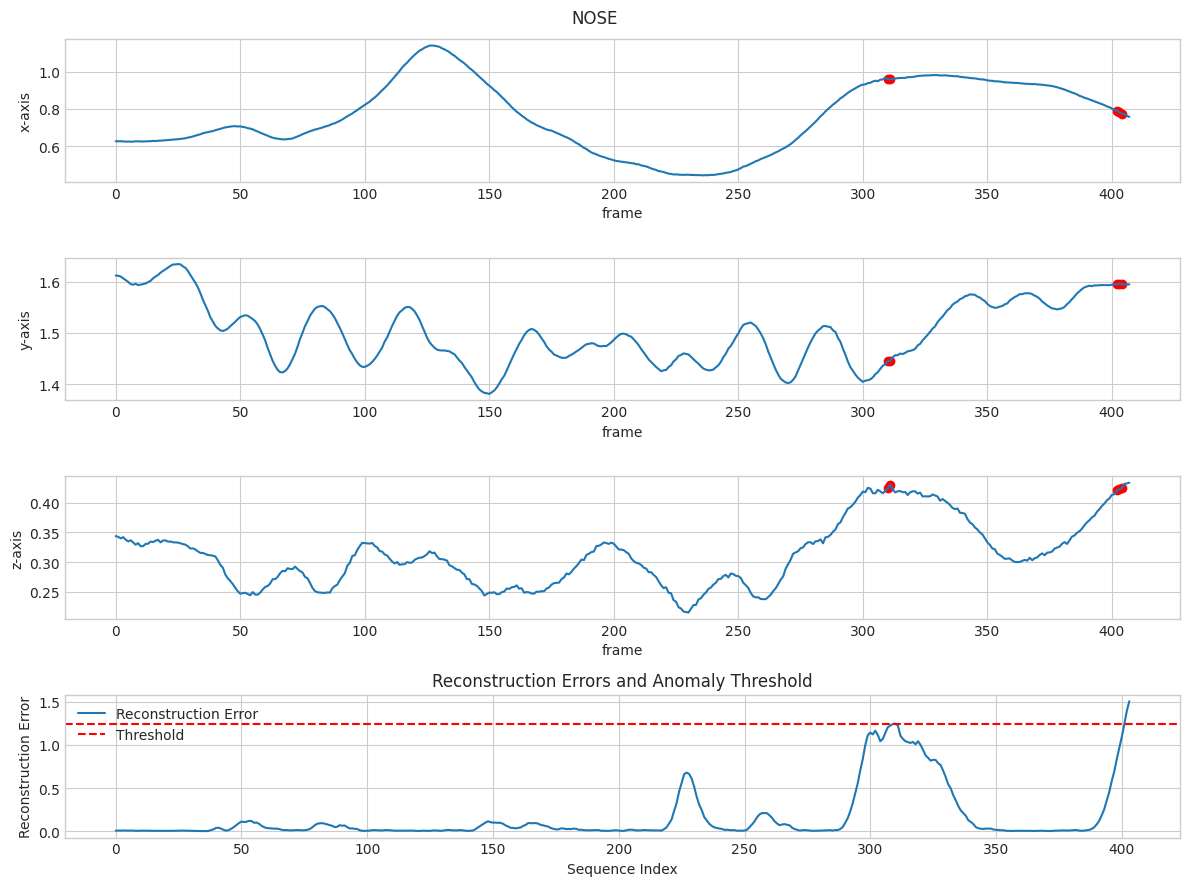

part_name: LEFT_EYE
anomaly indices size: 5


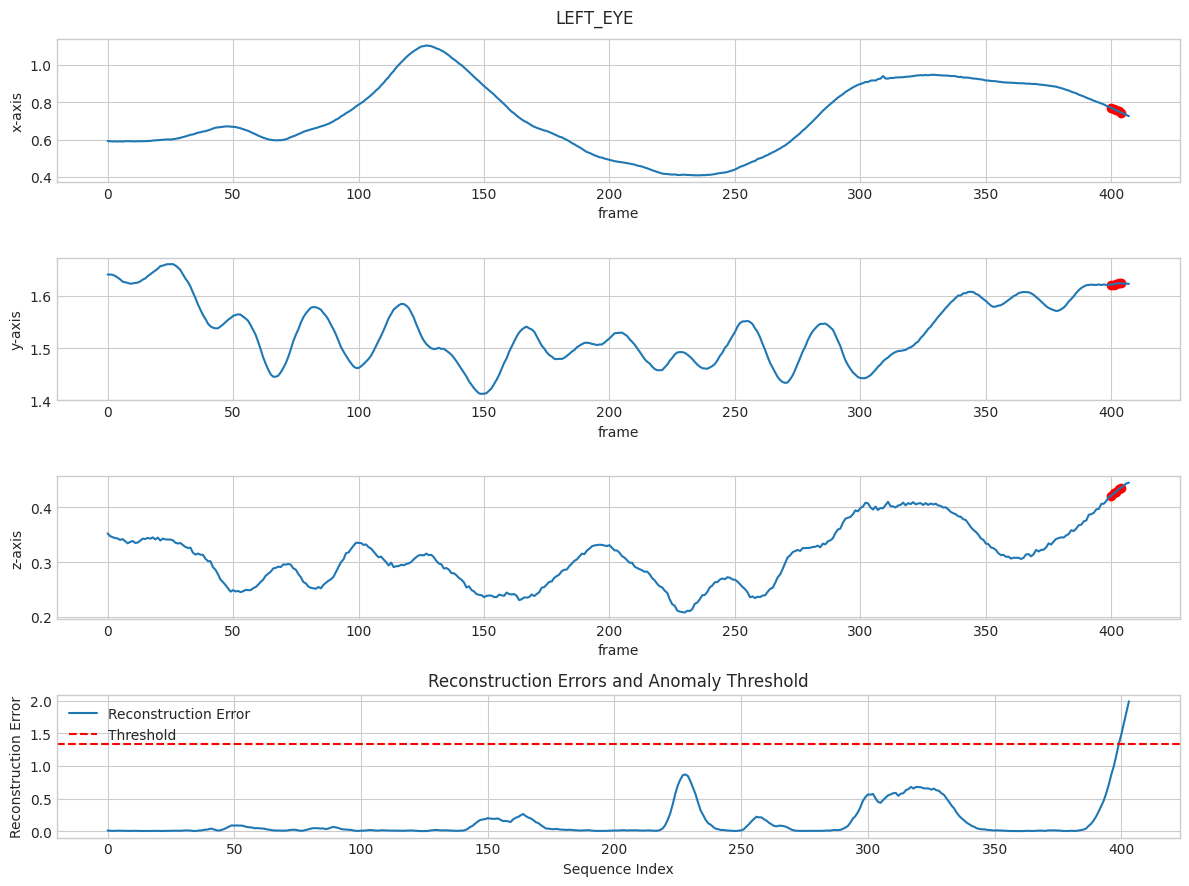

part_name: RIGHT_EYE
anomaly indices size: 5


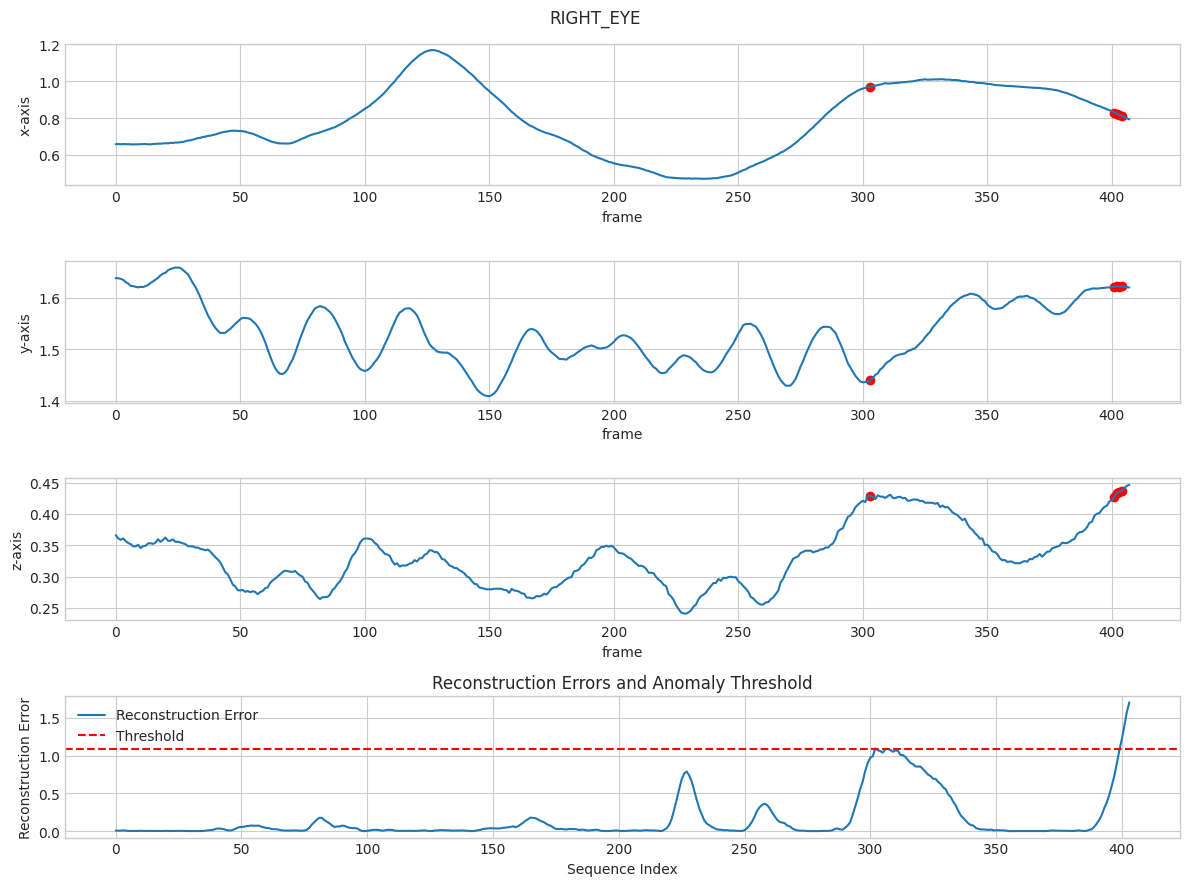

part_name: LEFT_EAR
anomaly indices size: 5


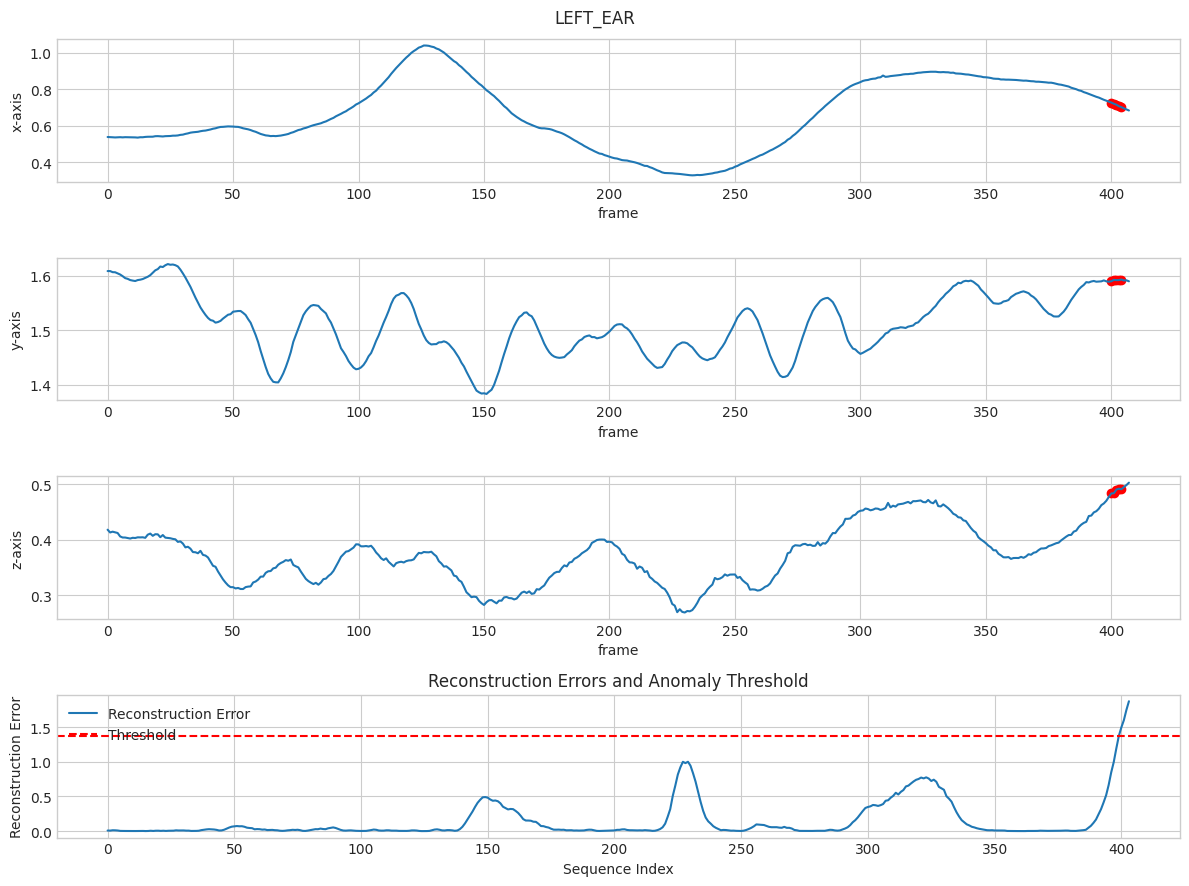

part_name: RIGHT_EAR
anomaly indices size: 5


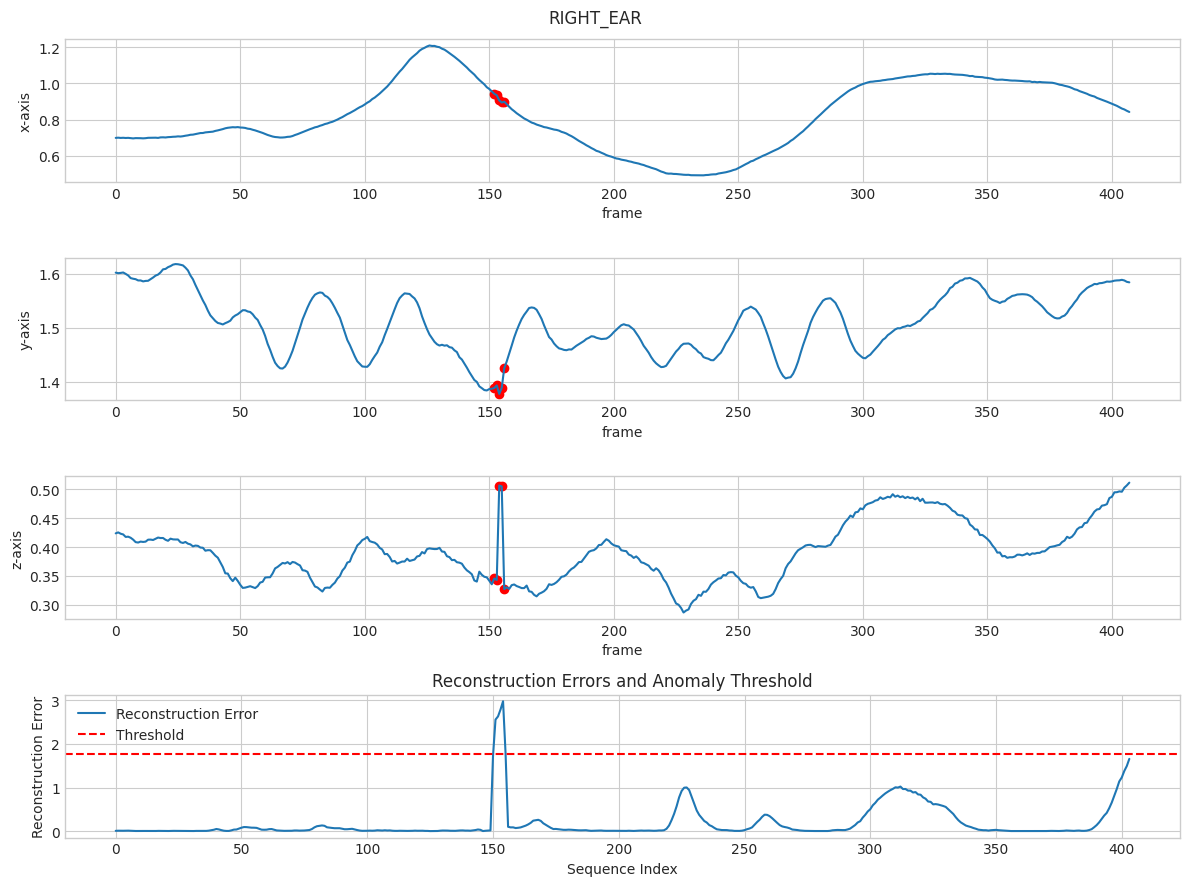

part_name: LEFT_SHOULDER
anomaly indices size: 5


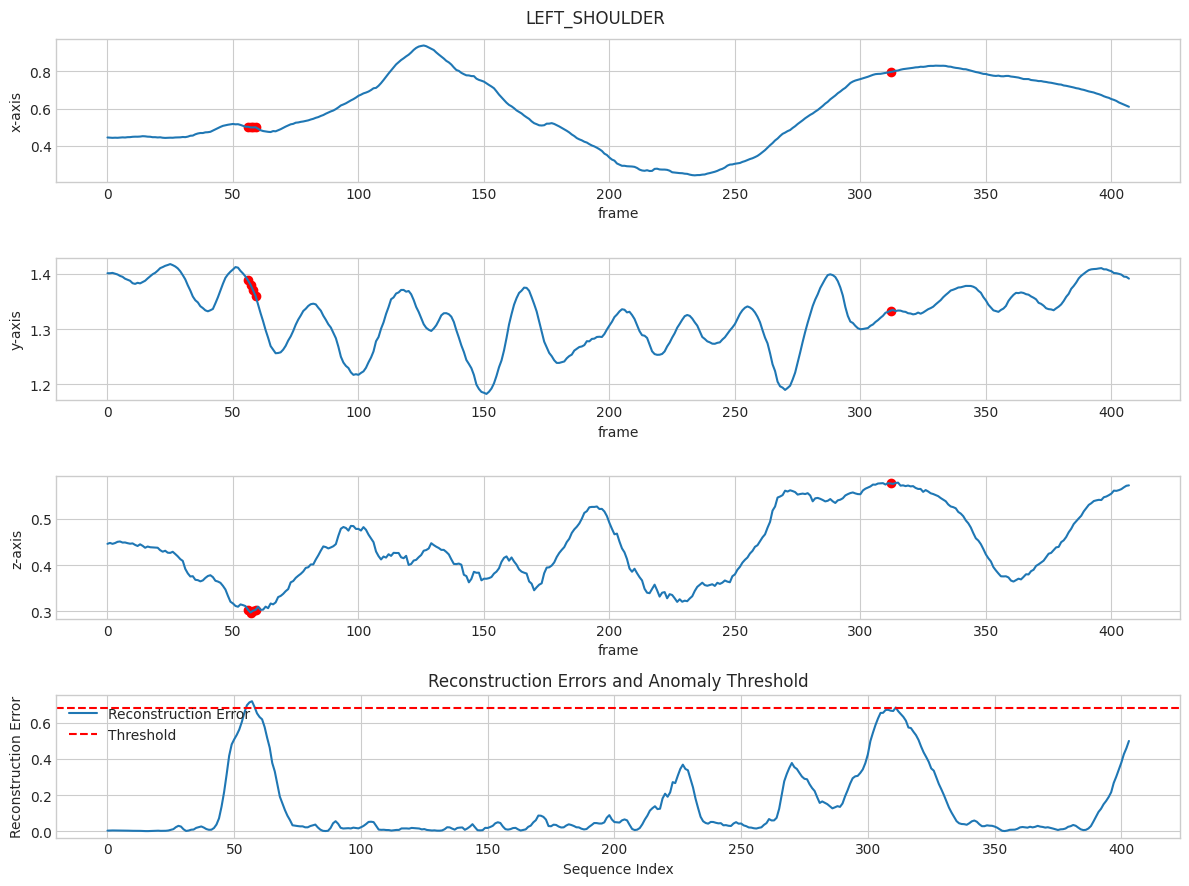

part_name: RIGHT_SHOULDER
anomaly indices size: 5


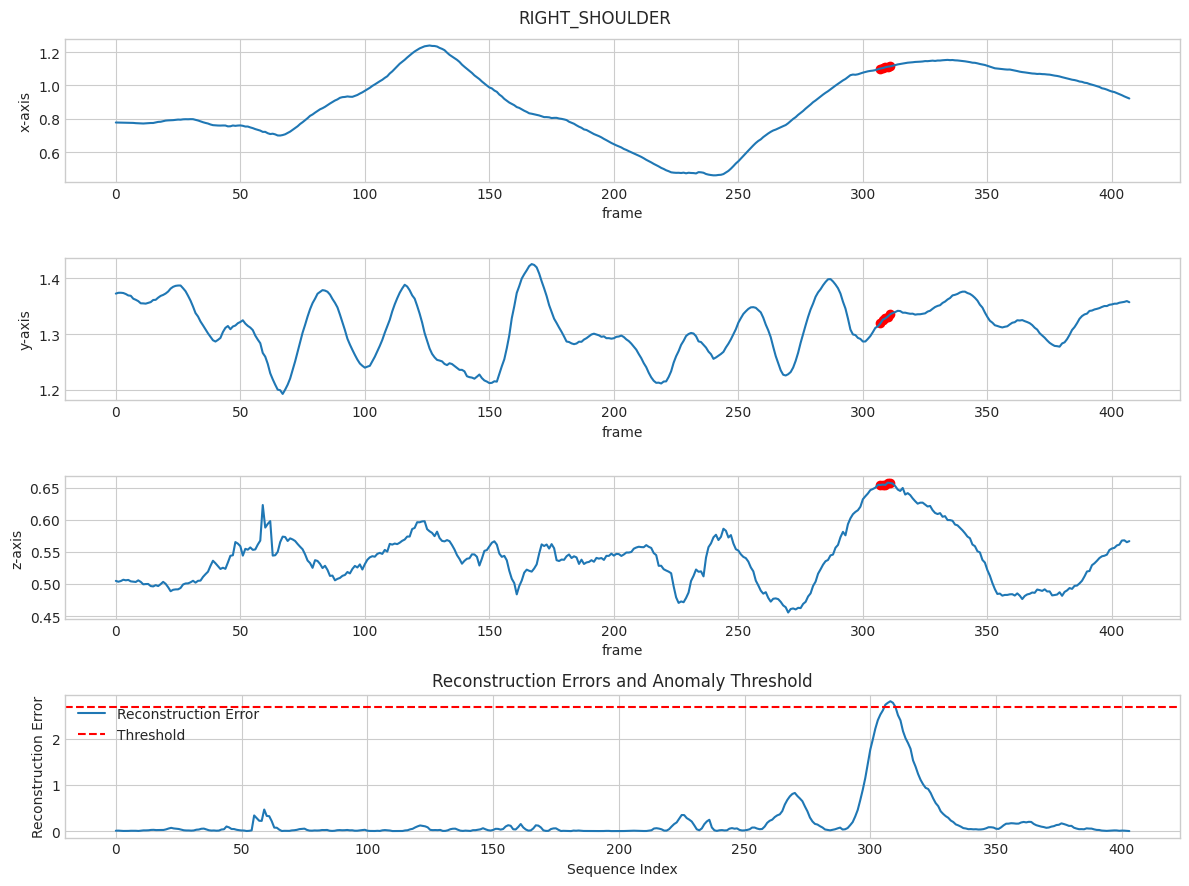

part_name: LEFT_ELBOW
anomaly indices size: 5


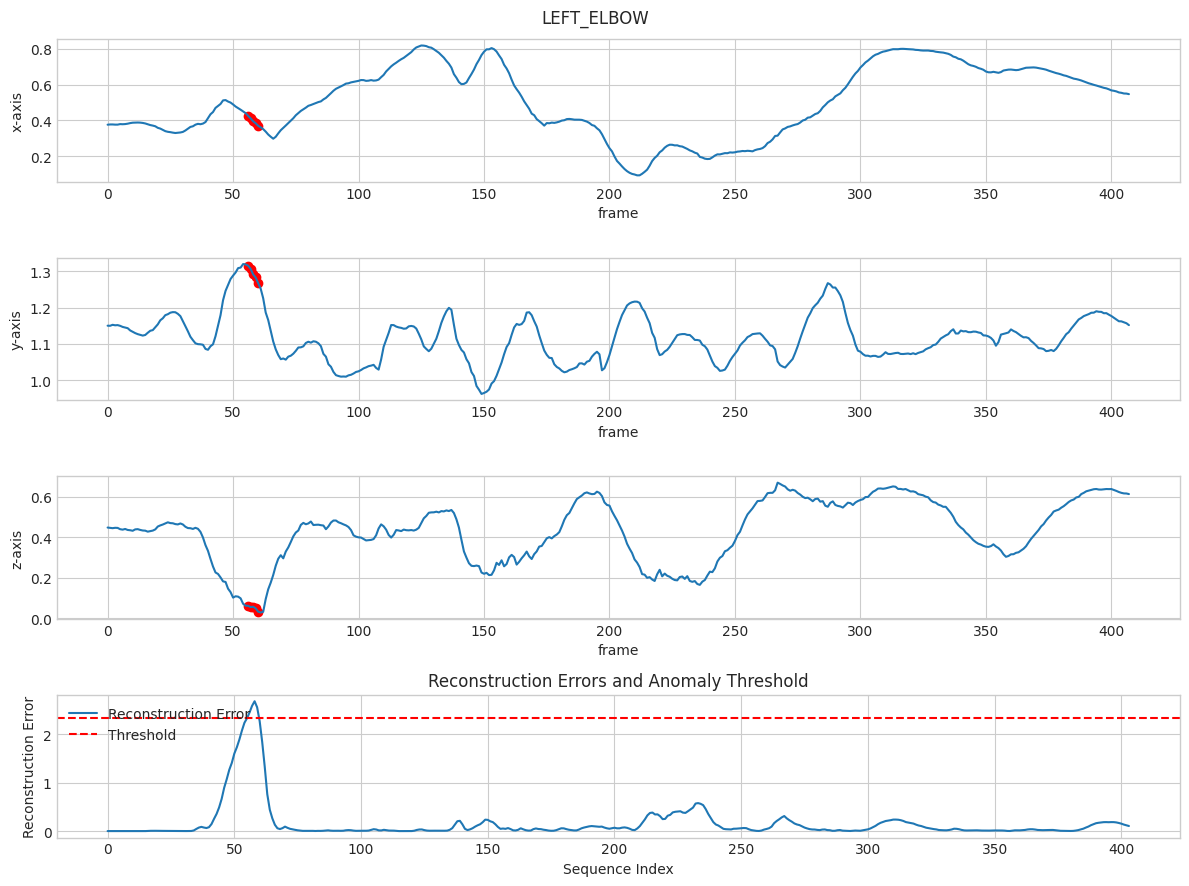

part_name: RIGHT_ELBOW
anomaly indices size: 5


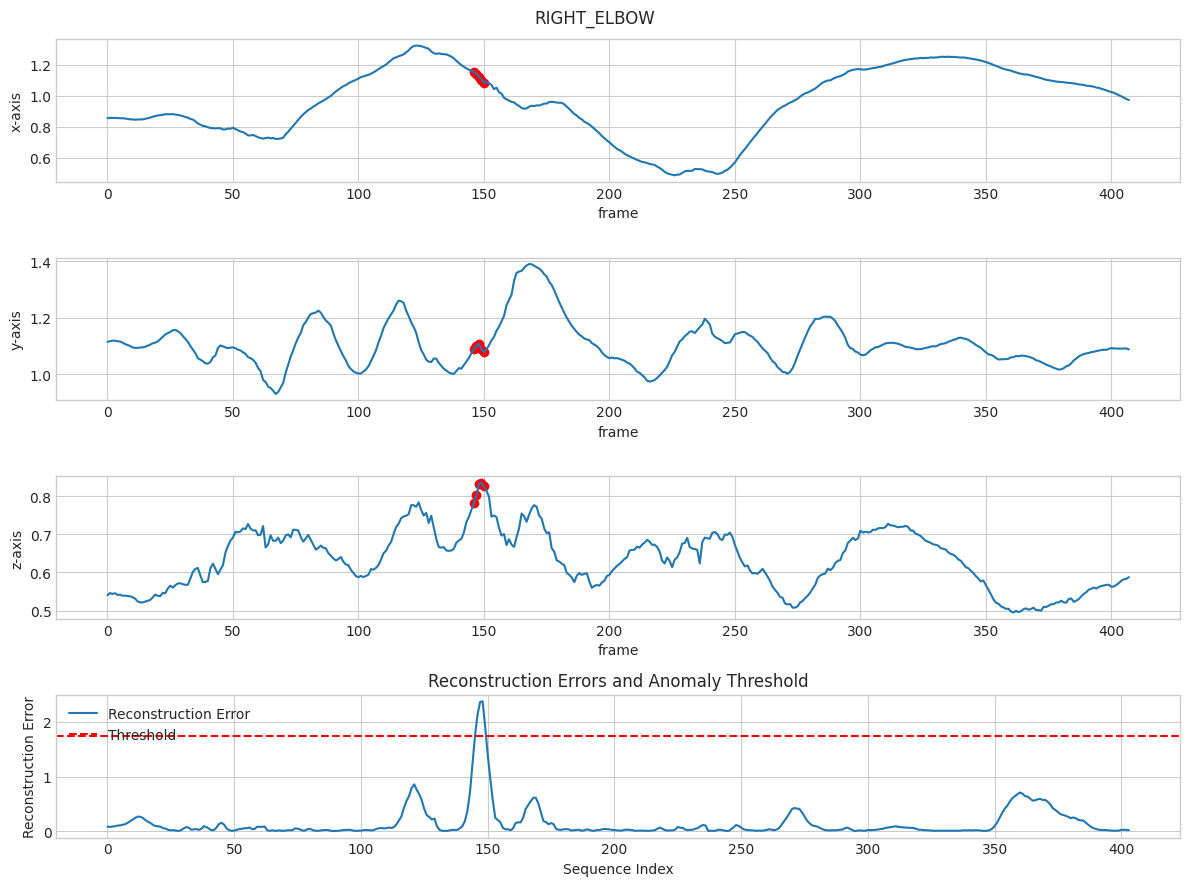

part_name: LEFT_WRIST
anomaly indices size: 5


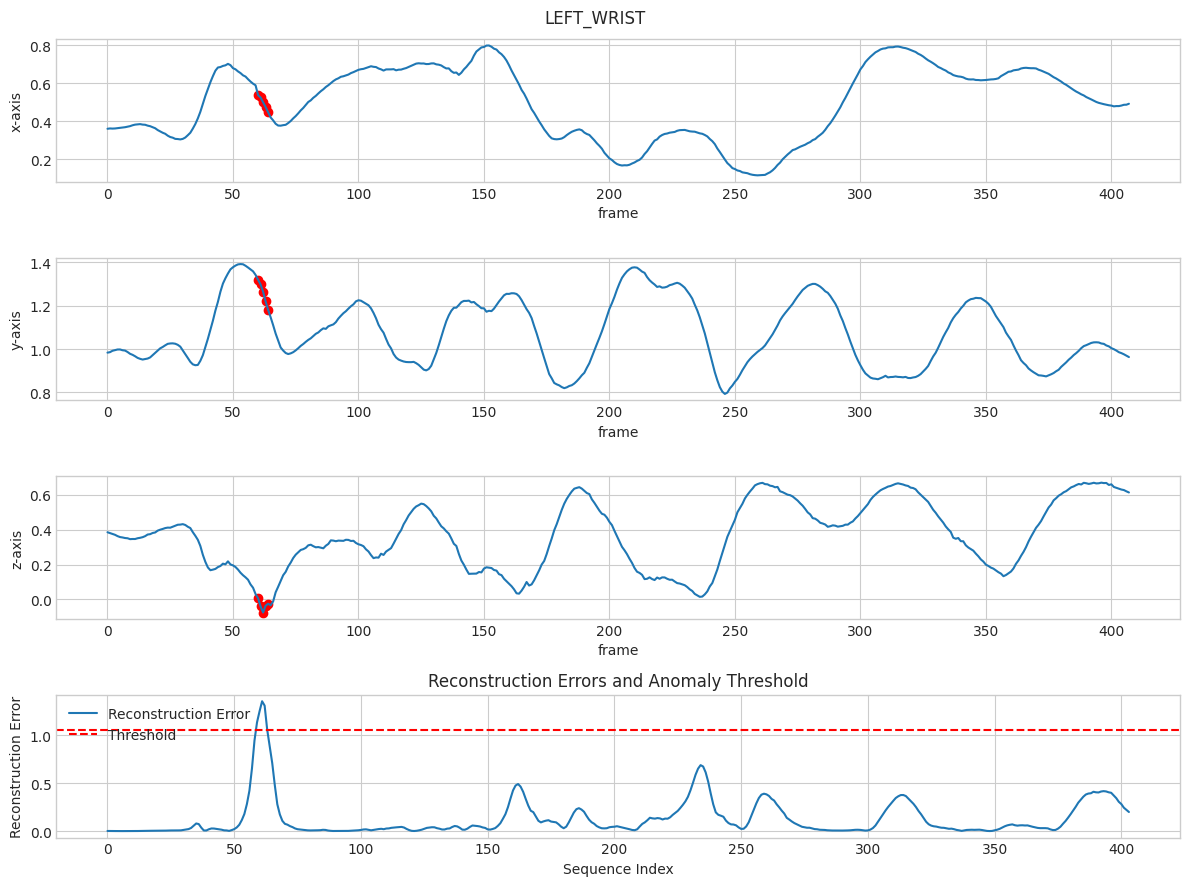

part_name: RIGHT_WRIST
anomaly indices size: 5


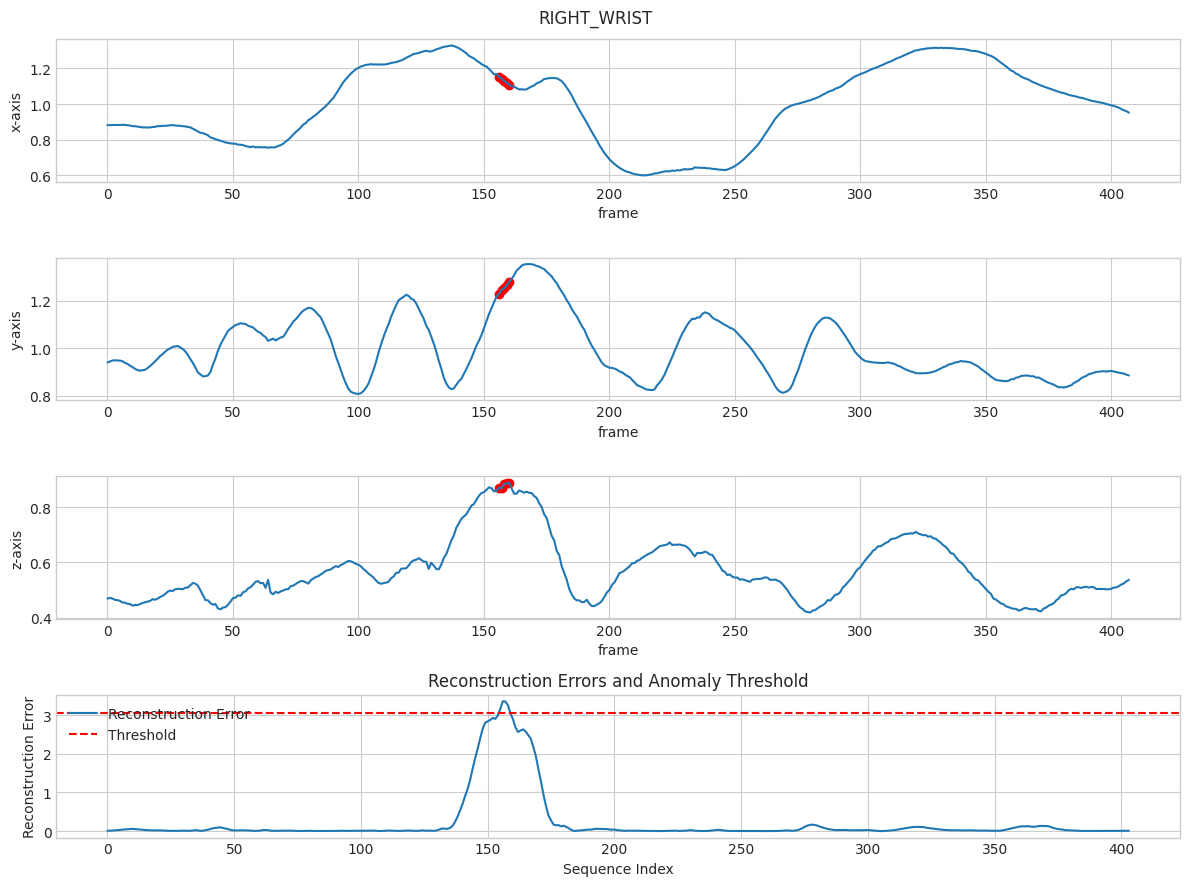

part_name: LEFT_GROIN
anomaly indices size: 5


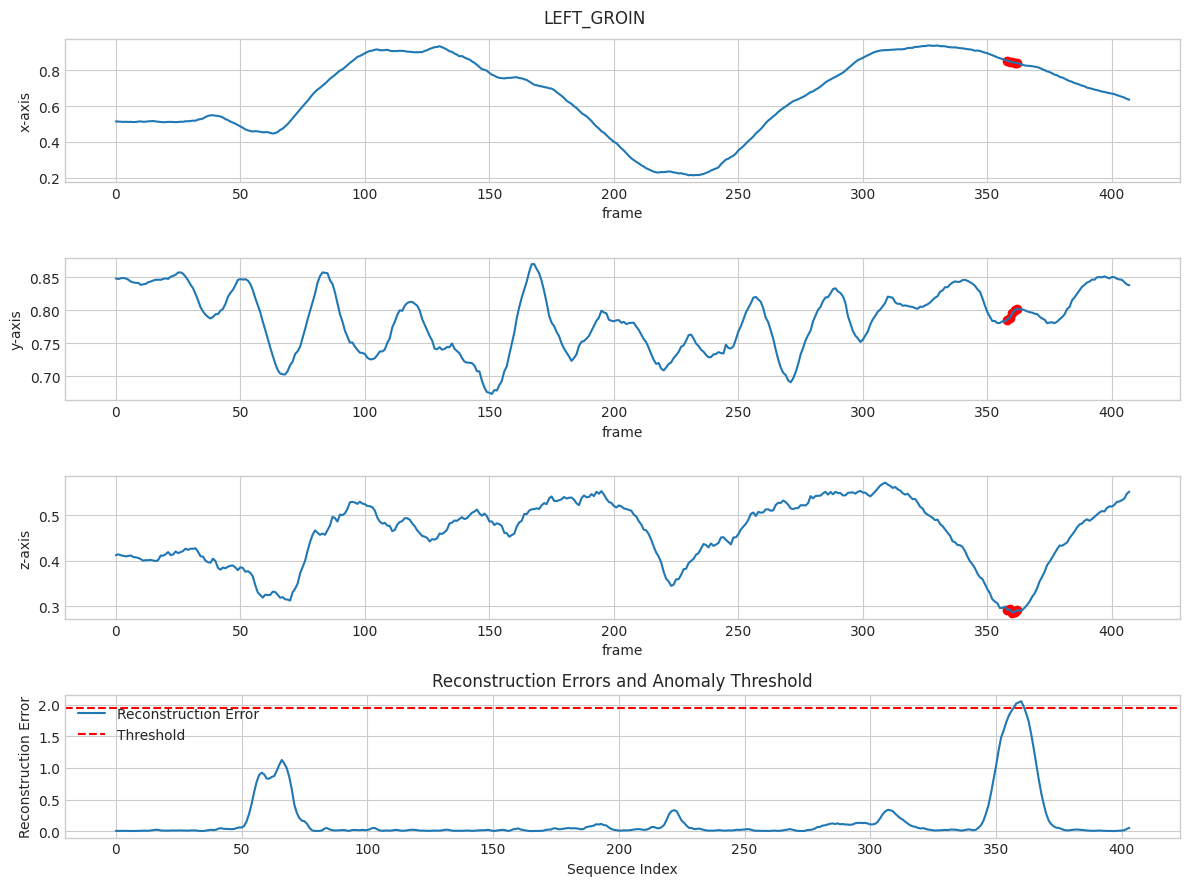

part_name: RIGHT_GROIN
anomaly indices size: 5


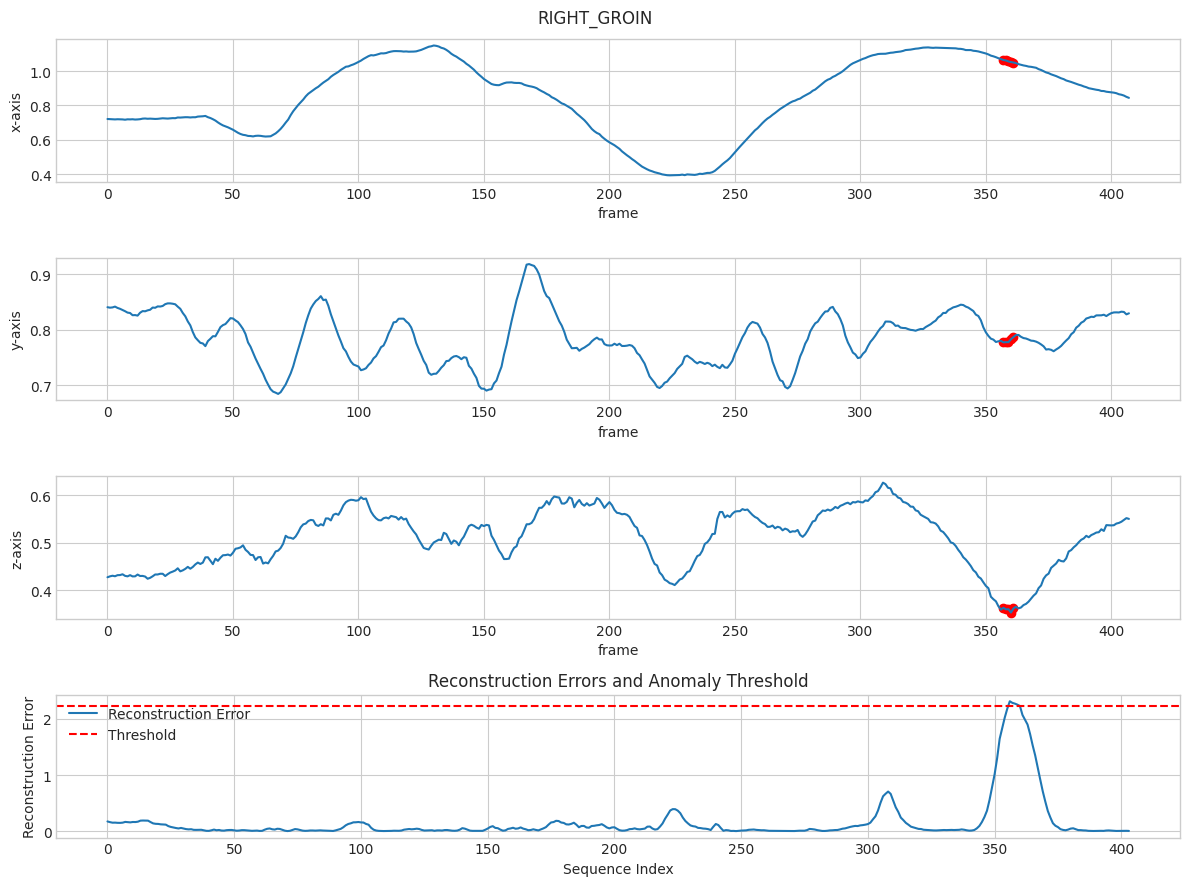

part_name: LEFT_KNEE
anomaly indices size: 5


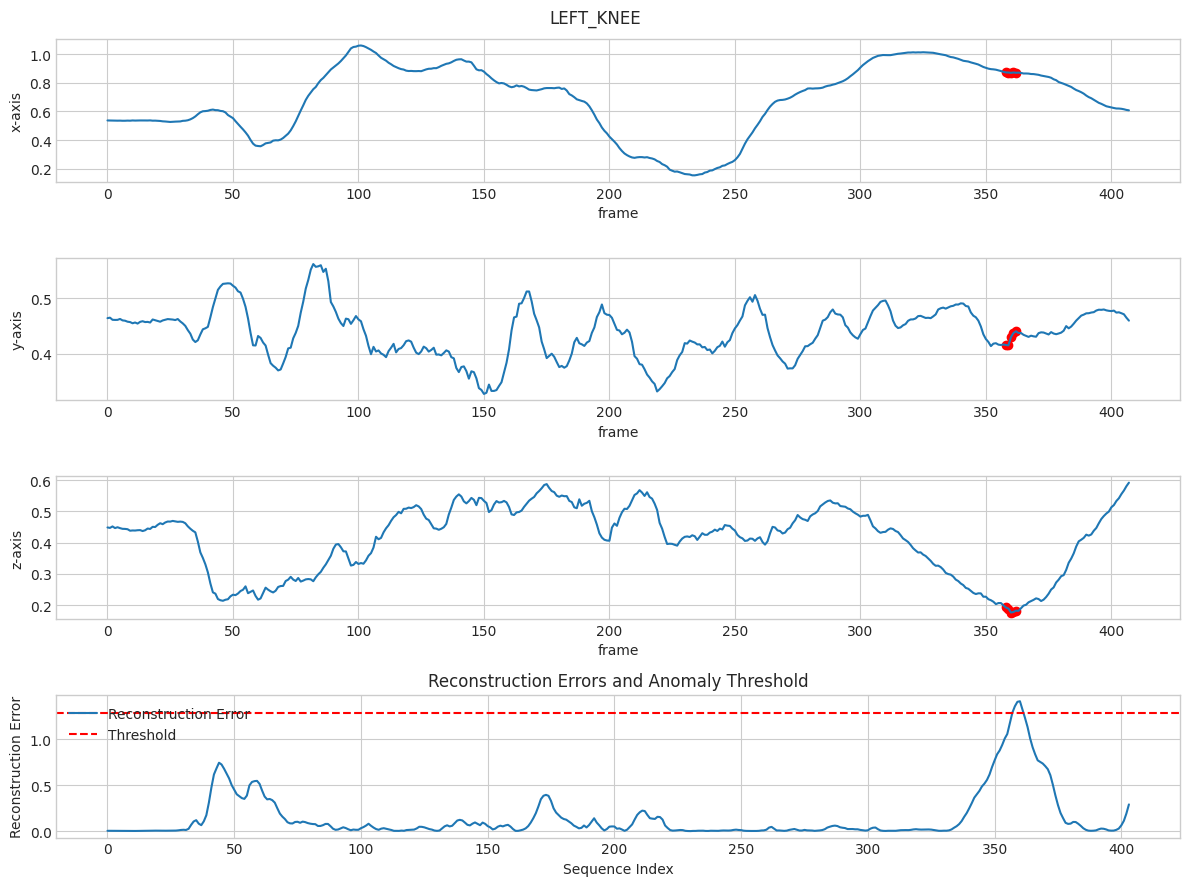

part_name: RIGHT_KNEE
anomaly indices size: 5


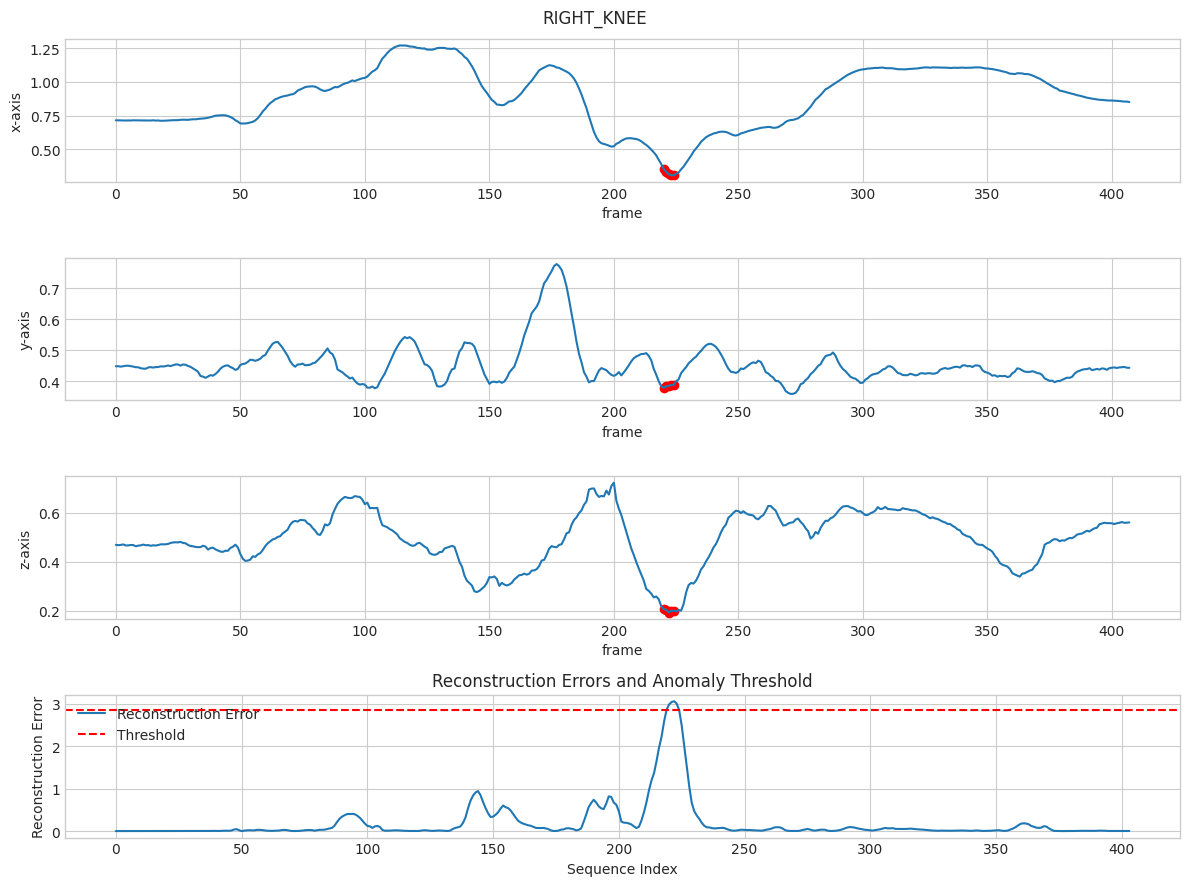

part_name: LEFT_ANKLE
anomaly indices size: 5


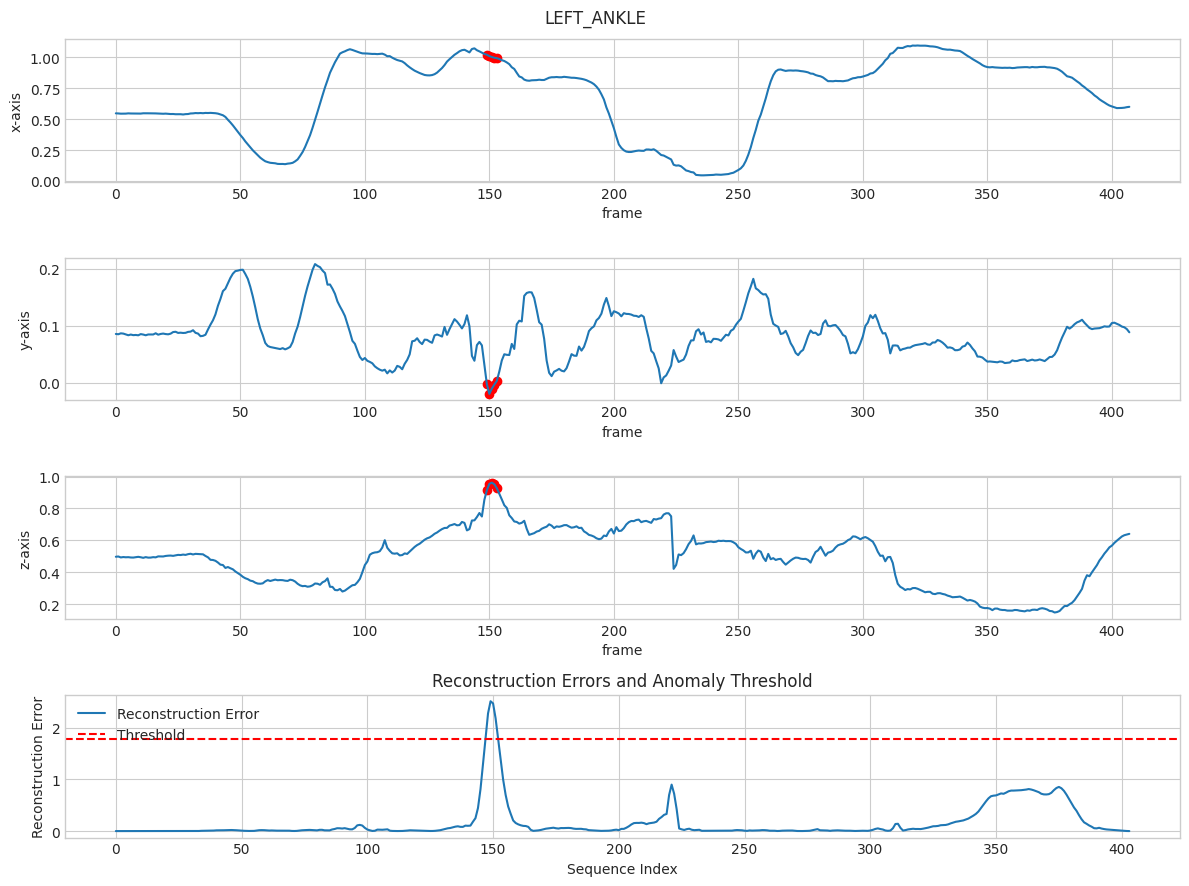

part_name: RIGHT_ANKLE
anomaly indices size: 5


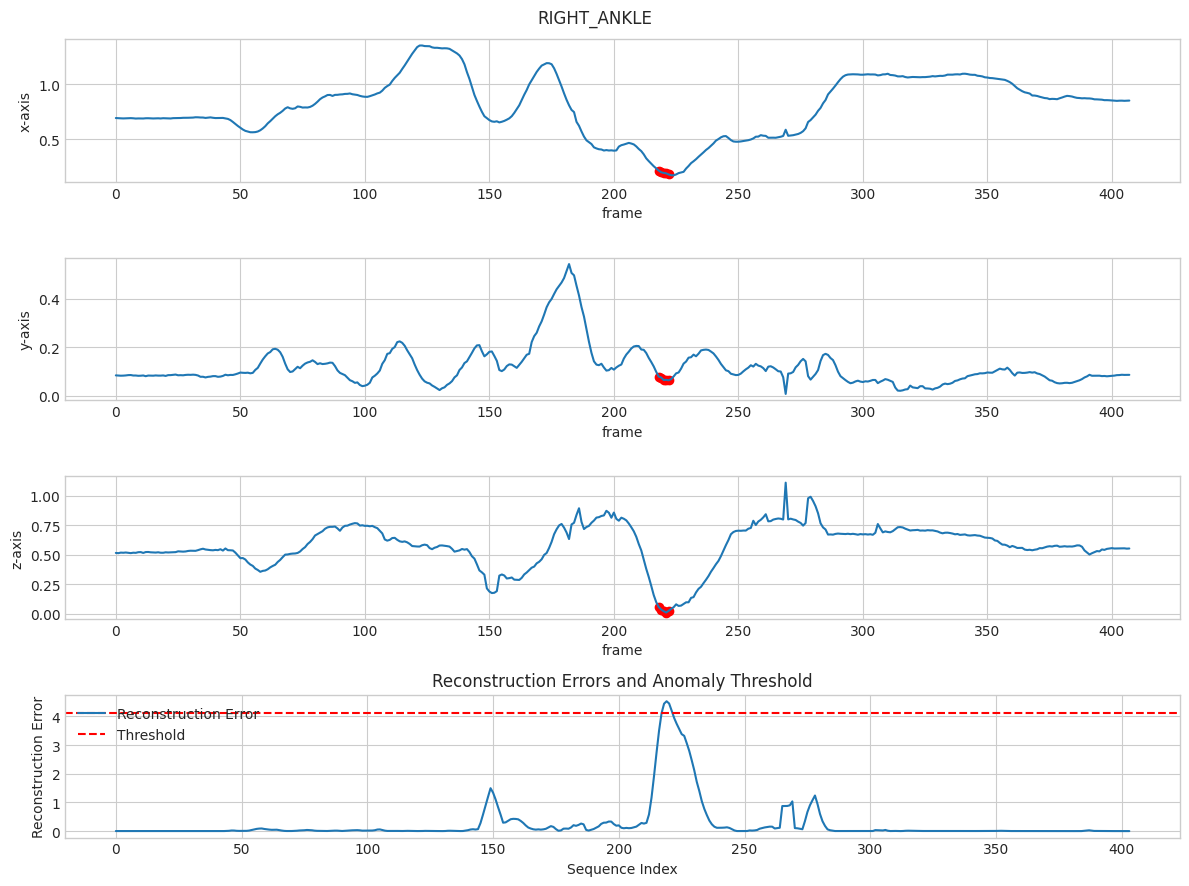

part_name: LEFT_BIG_TOE
anomaly indices size: 5


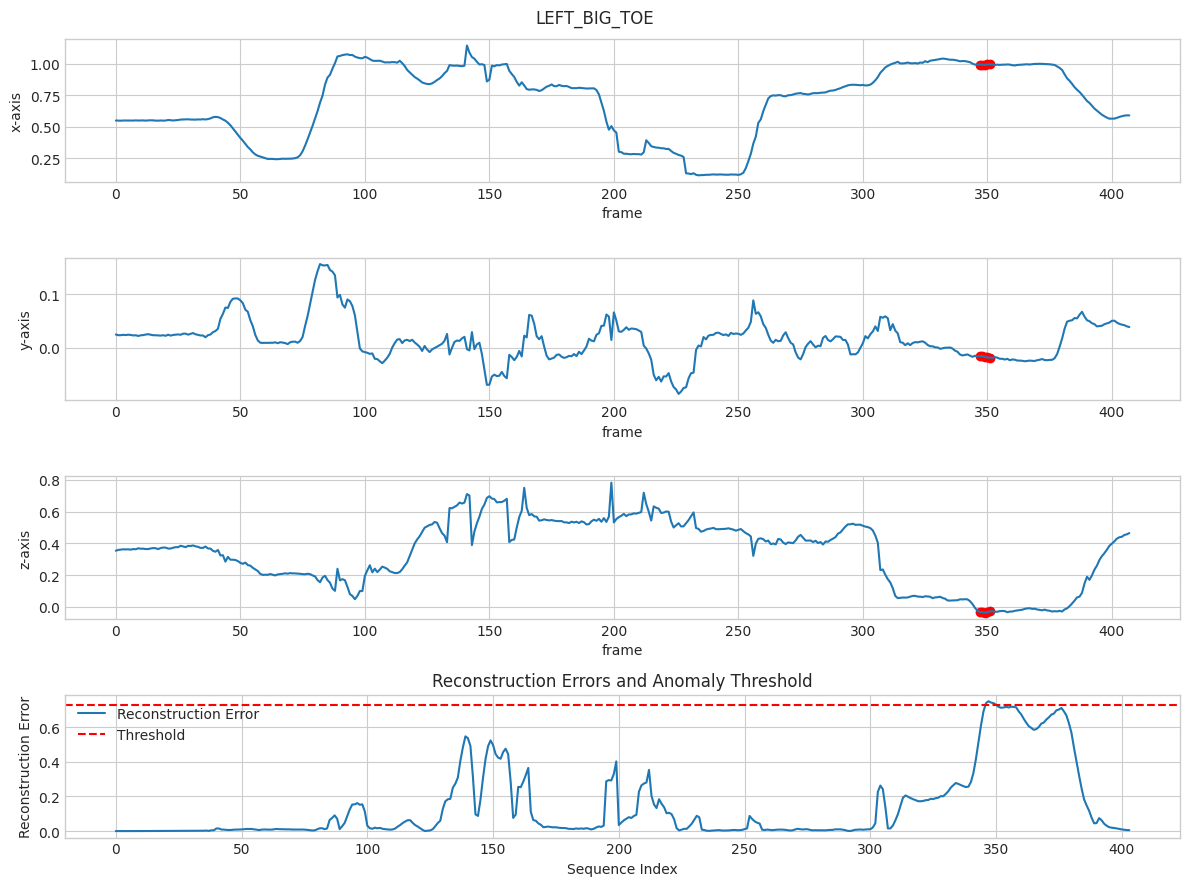

part_name: LEFT_LITTLE_TOE
anomaly indices size: 5


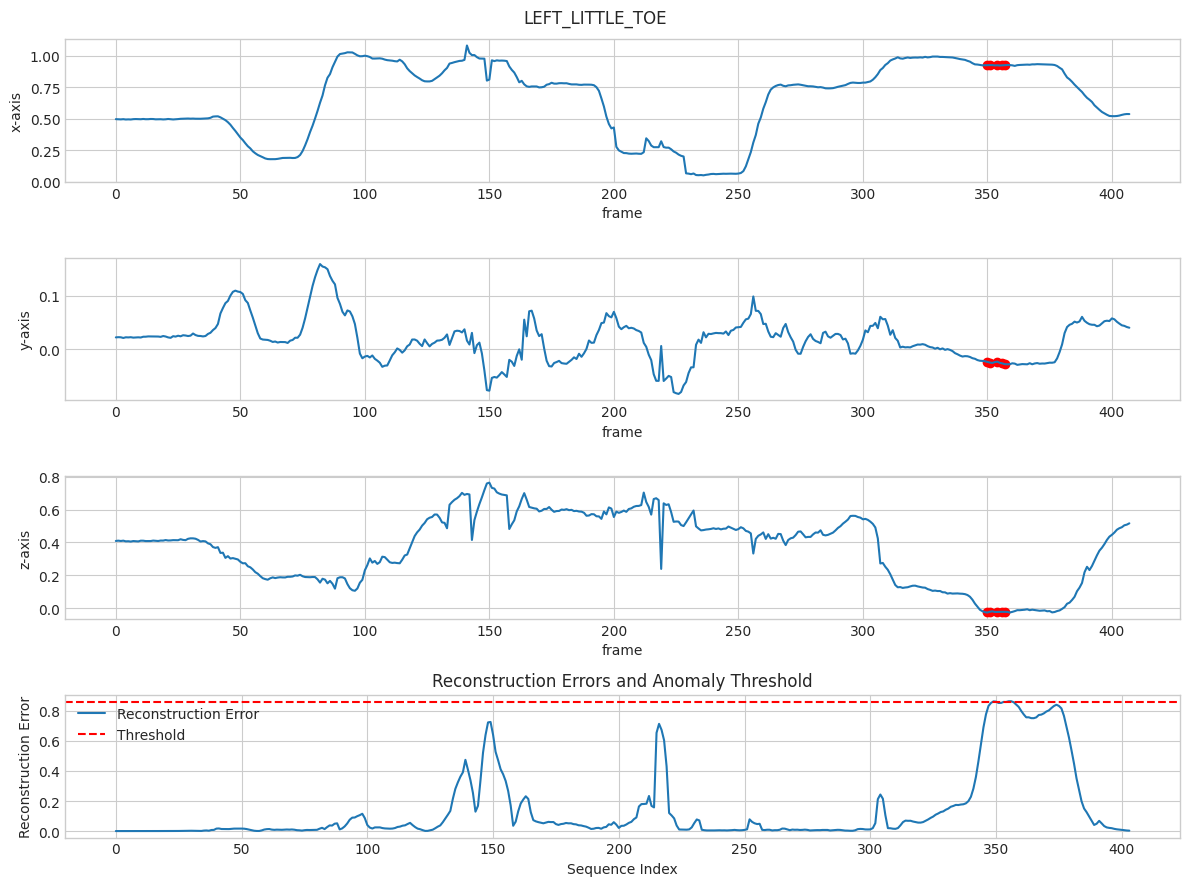

part_name: LEFT_HEEL
anomaly indices size: 5


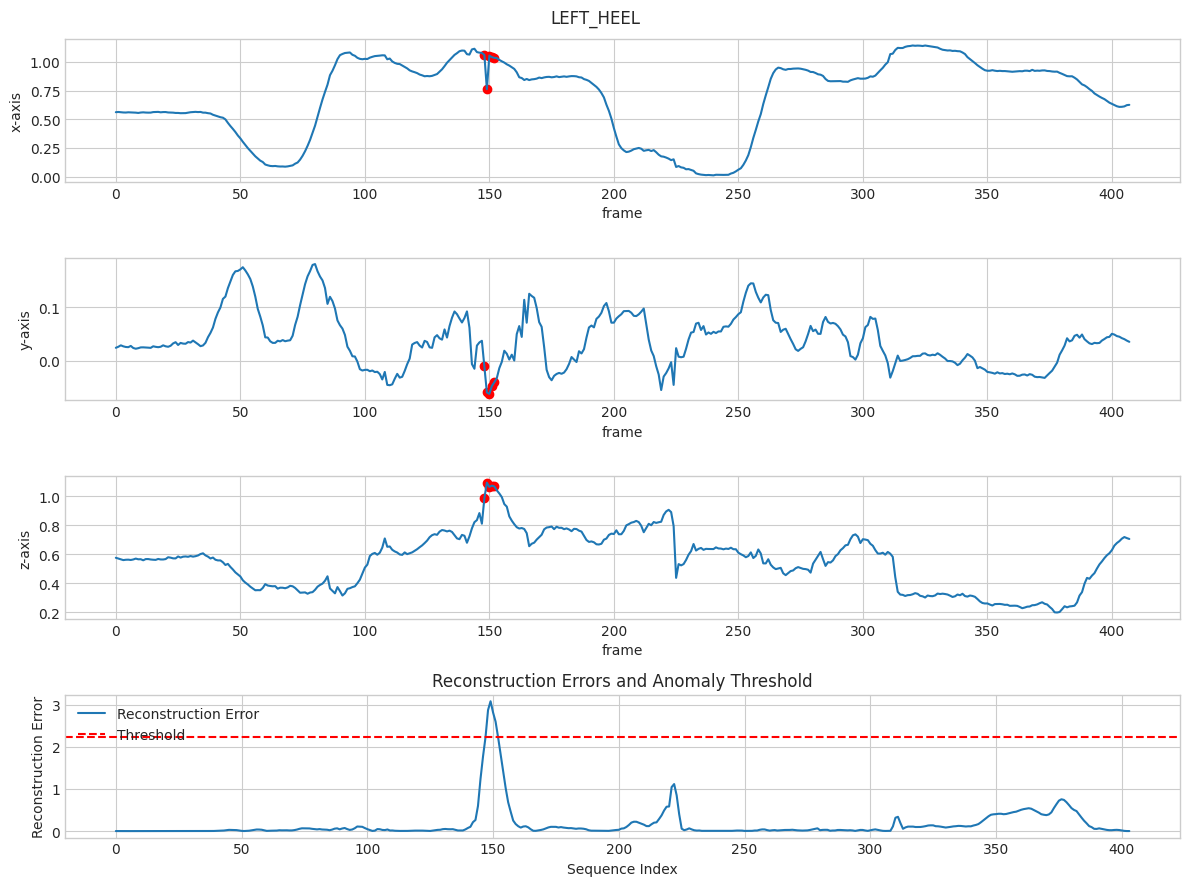

part_name: RIGHT_BIG_TOE
anomaly indices size: 5


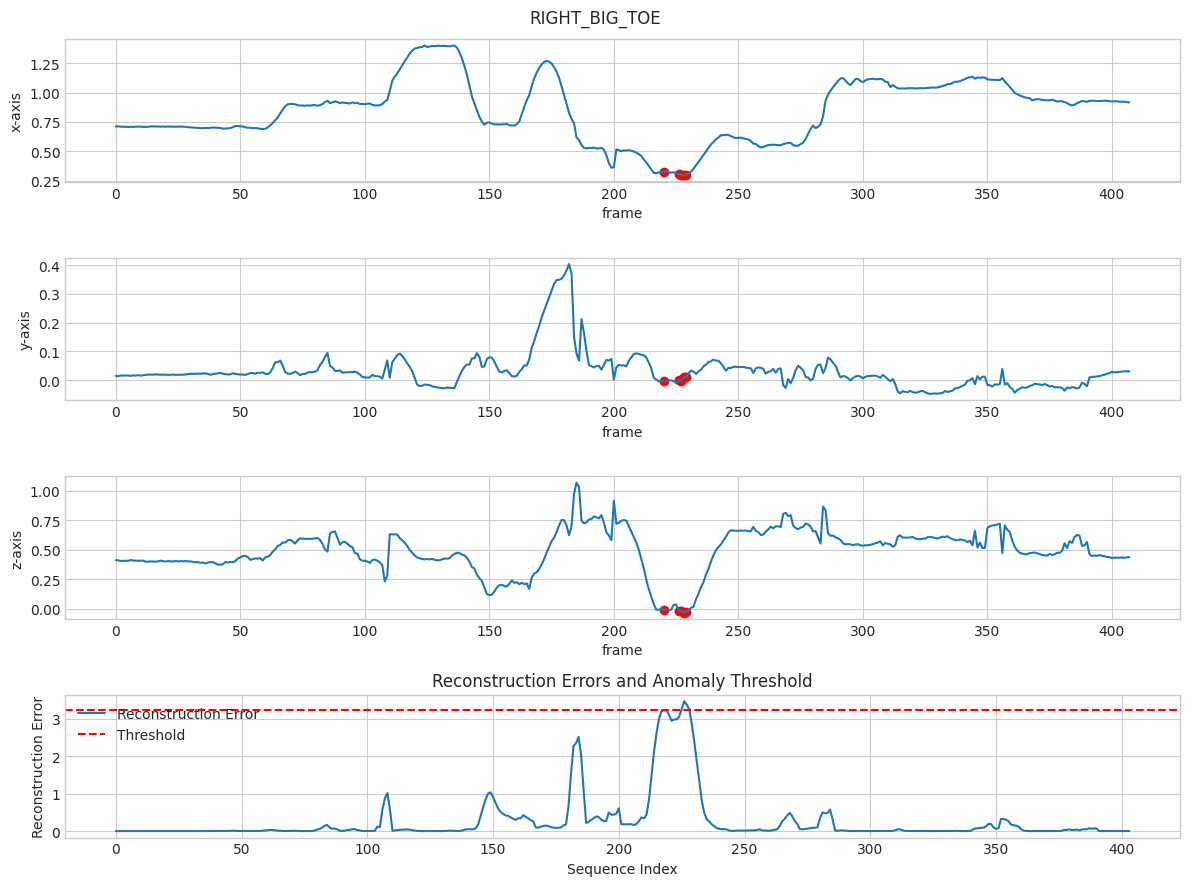

part_name: RIGHT_LITTLE_TOE
anomaly indices size: 5


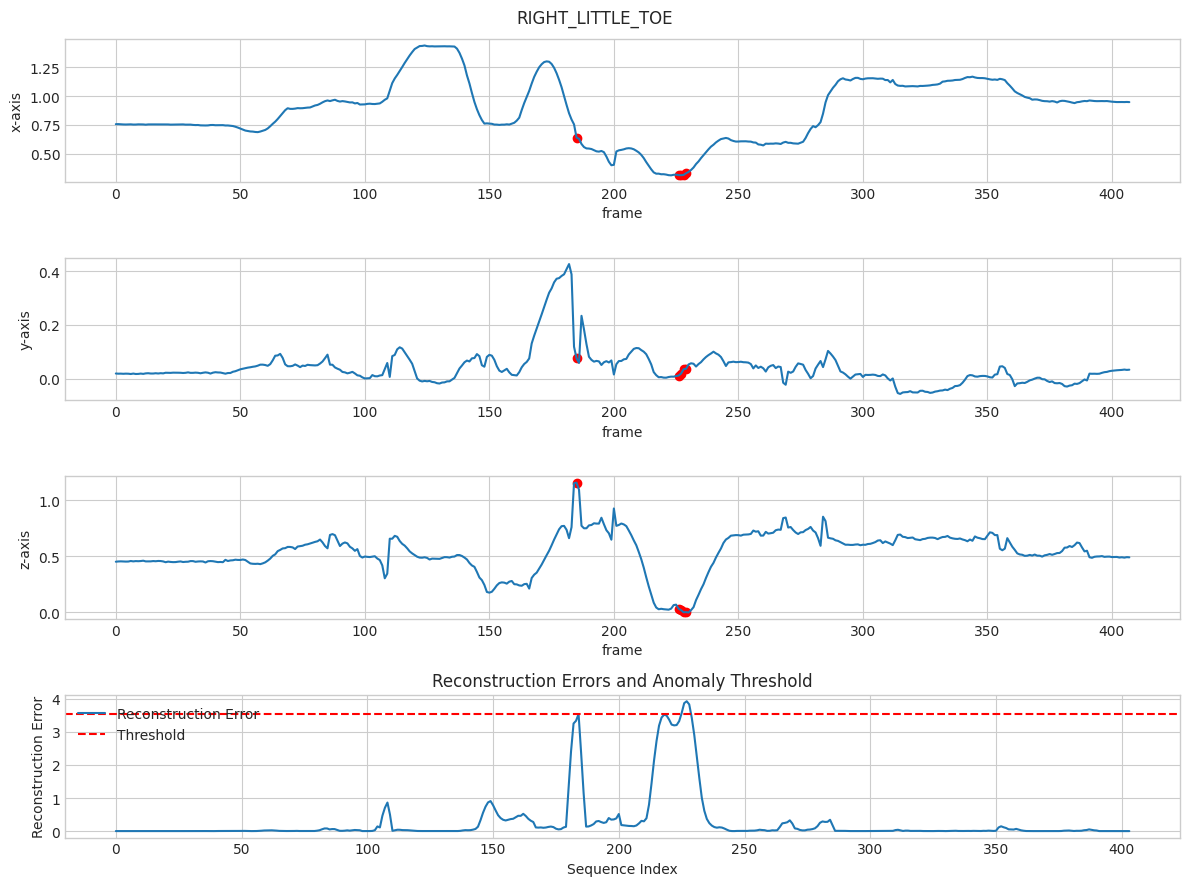

part_name: RIGHT_HEEL
anomaly indices size: 5


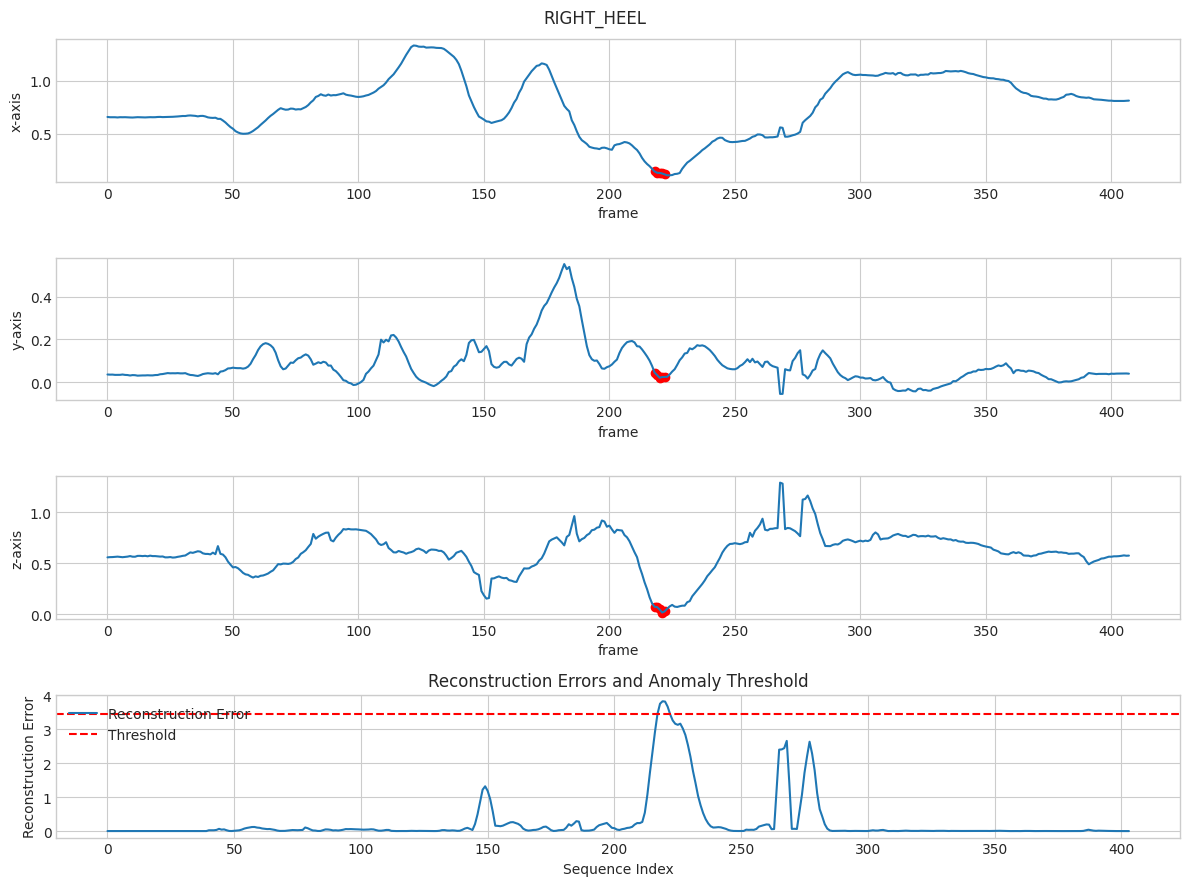

In [12]:
from skeleton_keypoints import keypoints_list

for part_name in keypoints_list:
    print(f"part_name: {part_name}")
    main(df, part_name)